In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd
from skgstat import models
import gstatsim as gsm

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time

import sys
sys.path.append('../../src')

In [2]:
ds = xr.load_dataset('abbot.nc')
ensemble = xr.load_dataarray(Path('results/ensemble_geoid_2000.nc'))

ensemble_mean = np.mean(ensemble.values, axis=0)
ensemble_std = np.std(ensemble.values, axis=0)
ensemble_diff = ds.bed-np.mean(ensemble.values, axis=0)

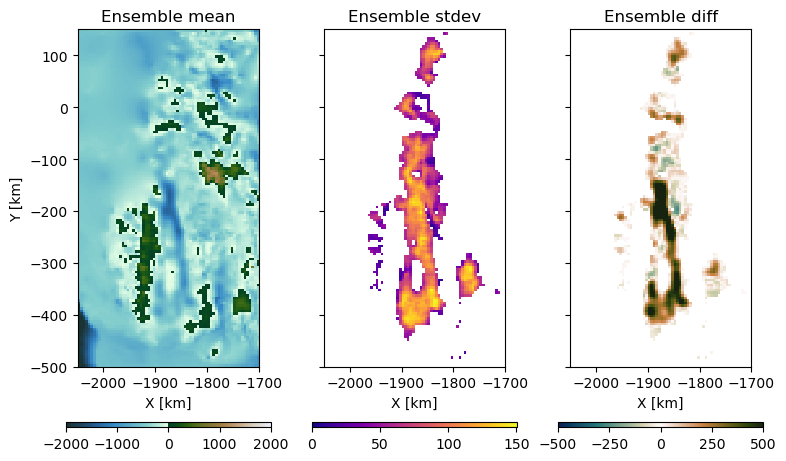

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(9,6), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble_mean, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Ensemble mean')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(ds.inv_msk, ensemble_std, np.nan), vmin=0, cmap='plasma')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Ensemble stdev')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(ds.inv_msk, ensemble_diff, np.nan), vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Ensemble diff')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

plt.show()

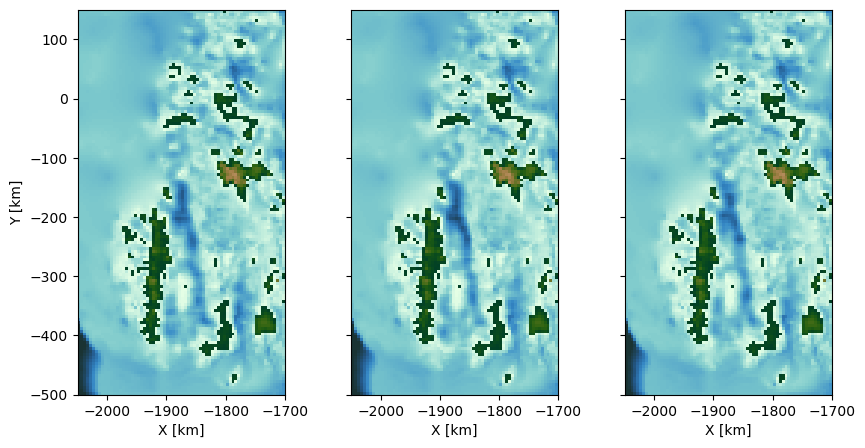

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(10,5), sharey=True)

for i, ax in enumerate(axs):
    ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble.sel(i=i), vmin=-2000, vmax=2000, cmap=cm.bukavu)
    ax.axis('scaled')
axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')
plt.show()

In [5]:
grid = xr.open_dataset(Path('G:/stochastic_bathymetry/raw_data/bedmachine/BedMachineAntarctica-v3.nc'))

xx, yy = np.meshgrid(ds.x, ds.y)

# trim original BedMachine, get coordinates
x_trim = (grid.x >= np.min(xx)) & (grid.x <= np.max(xx))
y_trim = (grid.y >= np.min(yy)) & (grid.y <= np.max(yy))
grid = grid.sel(x=x_trim, y=y_trim)
xx_bm, yy_bm = np.meshgrid(grid.x.values, grid.y.values)

# interpolate inversion mask to original resolution
kn = vd.KNeighbors(1)
kn.fit((xx.flatten(), yy.flatten()), ds.inv_msk.values.flatten())
preds_msk = kn.predict((xx_bm, yy_bm))
preds_msk = preds_msk.reshape(xx_bm.shape) > 0.5

ensemble = xr.load_dataarray(Path('results/ensemble_geoid_500.nc'))

ensemble_mean = np.mean(ensemble.values, axis=0)
ensemble_std = np.std(ensemble.values, axis=0)
ensemble_diff = grid.bed-np.mean(ensemble.values, axis=0)

xx_dens, yy_dens = np.meshgrid(grid.x, grid.y)

kn = vd.KNeighbors(1)
kn.fit((xx.flatten(), yy.flatten()), ds.inv_msk.values.flatten())
preds = kn.predict((xx_dens, yy_dens))
inv_dens = preds.reshape(xx_dens.shape) > 0.5

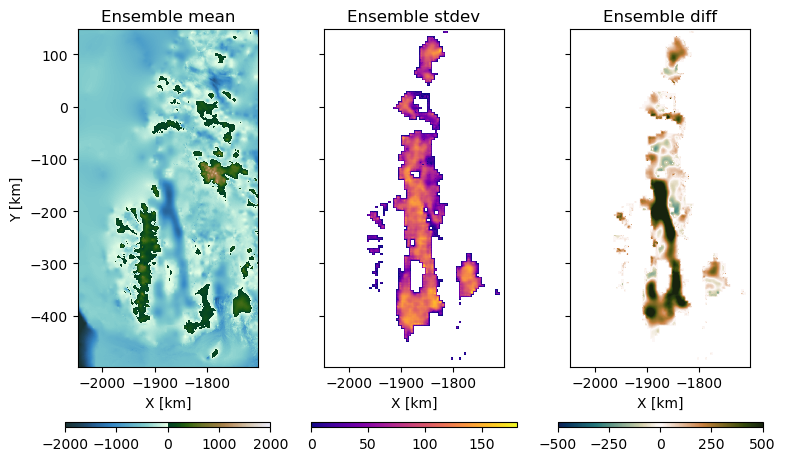

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(9,6), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble_mean, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Ensemble mean')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(preds_msk, ensemble_std, np.nan), vmin=0, cmap='plasma')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Ensemble stdev')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(preds_msk, ensemble_diff, np.nan), vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Ensemble diff')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.12, aspect=40)

plt.show()

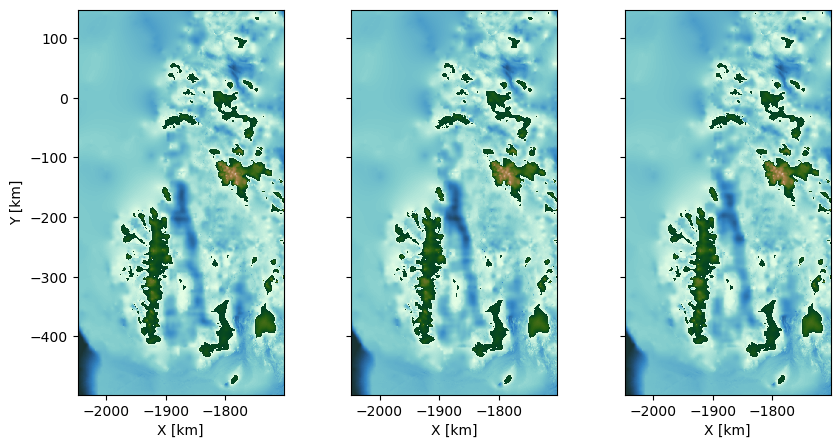

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10,5), sharey=True)

for i, ax in enumerate(axs):
    ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble.sel(i=i), vmin=-2000, vmax=2000, cmap=cm.bukavu)
    ax.axis('scaled')
axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')
plt.show()

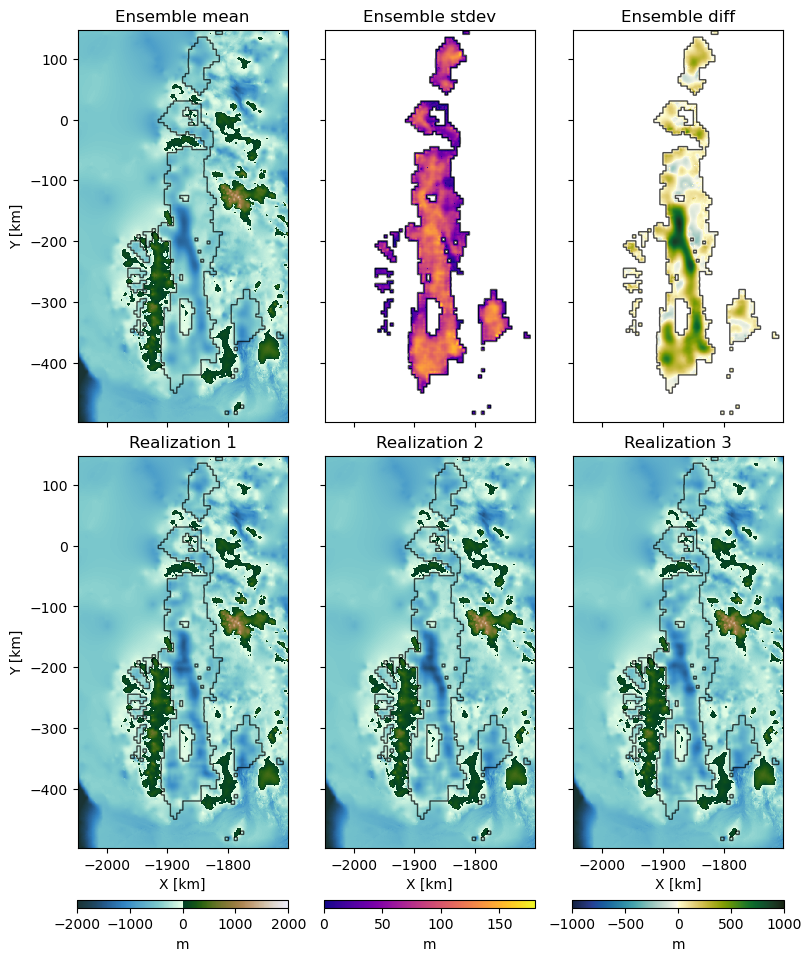

In [18]:
fig = plt.figure(figsize=(8,9.5), constrained_layout=True)

gs = GridSpec(3, 3, figure=fig, height_ratios=[1,1,0.02], wspace=0.05, hspace=0.0)

ax = fig.add_subplot(gs[0,0])
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble_mean, vmin=-2000, vmax=2000, cmap=cm.bukavu, rasterized=True)
ax.axis('scaled')
ax.set_ylabel('Y [km]')
ax.set_title('Ensemble mean')
ax.set_xticklabels([])
cax = fig.add_subplot(gs[2,0])
plt.colorbar(im, cax=cax, orientation='horizontal', pad=0.12, aspect=40, label='m')
cs1 = ax.contour(grid.x/1000, grid.y/1000, inv_dens, levels=[0], colors='k', antialiased=True, linewidths=1, alpha=0.7)

ax = fig.add_subplot(gs[0,1])
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(preds_msk, ensemble_std, np.nan), vmin=0, cmap='plasma', rasterized=True)
ax.axis('scaled')
ax.set_title('Ensemble stdev')
ax.set_xticklabels([])
ax.set_yticklabels([])
cax = fig.add_subplot(gs[2,1])
plt.colorbar(im, cax=cax, orientation='horizontal', pad=0.12, aspect=40, label='m')
cs1 = ax.contour(grid.x/1000, grid.y/1000, inv_dens, levels=[0], colors='k', antialiased=True, linewidths=1, alpha=0.7)

ax = fig.add_subplot(gs[0,2])
im = ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, np.where(preds_msk, ensemble_diff, np.nan), vmin=-1000, vmax=1000, cmap='cmo.delta', rasterized=True)
ax.axis('scaled')
ax.set_title('Ensemble diff')
ax.set_xticklabels([])
ax.set_yticklabels([])
cax = fig.add_subplot(gs[2,2])
plt.colorbar(im, cax=cax, orientation='horizontal', pad=0.12, aspect=40, label='m')
cs1 = ax.contour(grid.x/1000, grid.y/1000, inv_dens, levels=[0], colors='k', antialiased=True, linewidths=1, alpha=0.7)

axs = []
for i in range(3):
    axs.append(fig.add_subplot(gs[1,i]))

for i, ax in enumerate(axs):
    ax.pcolormesh(ensemble.x/1000, ensemble.y/1000, ensemble.sel(i=i), vmin=-2000, vmax=2000, cmap=cm.bukavu, rasterized=True)
    ax.axis('scaled')
    ax.set_title(f'Realization {i+1}')
    cs1 = ax.contour(grid.x/1000, grid.y/1000, inv_dens, levels=[0], colors='k', antialiased=True, linewidths=1, alpha=0.7)
axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

plt.savefig(Path('../../figures/png/abbot_combo.png'), dpi=300, bbox_inches='tight')
plt.savefig(Path('../../figures/svg/abbot_combo.svg'), dpi=300, bbox_inches='tight')
plt.show()